# 6.4: Supervised Machine Learning: Regression
** **

## This script contains the following:

1. Importing libraries and files


2. Data cleaning


3. Data prep for regression analysis


4. Regression analysis

Bonus: performance improvement after removing outliers
** **


### 1. Importing libraries and files
** **

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# This option ensures that the graphs you create are displayed within the notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# Selecting shared path

path = r'C:\Users\mehrn\OneDrive\Desktop\CareerFoundry Materials\Tasks\06 Advanced Analytics\15-03-2023 Canada Wildfires Analysis'

In [4]:
# Selecting necessary columns

columns = ['src_agency', 'rep_date', 'size', 'cause', 'Maximum Temperature (C)', 'Speed of Maximum Wind Gust (km/h)', 'size_class']

In [5]:
# Importing wrangled fires dataframe and "weather of Vancouver" open dataset provided by Environment Canada

df_fires = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'wthr_fires.pkl'))

### 2. Data cleaning
** **

In [6]:
# Filtering columns out in a (.pkl read above) datafram

df_fires = df_fires.filter(columns)

In [7]:
df_fires.head()

,src_agency,rep_date,size,cause,Maximum Temperature (C),Speed of Maximum Wind Gust (km/h),size_class
0,AB,2006-06-15,5.70,L,17.9,NaN,Class C
1,AB,2006-06-15,38.70,L,17.9,NaN,Class C
2,AB,2006-06-15,0.45,H,19.0,NaN,Class B
3,AB,2006-06-15,0.01,H,17.9,NaN,Class A
4,AB,2006-06-15,0.10,L,17.9,NaN,Class A


In [8]:
df_fires.shape

(30364, 7)

In [9]:
# Confirming that fires from the past 20 years (2002-2021) have been imported

df_fires['rep_date'].value_counts(dropna = False)

2002-06-15    135
2004-07-15    127
2018-06-22    117
2008-05-19    102
2015-05-18    101
             ... 
2003-12-05      1
2000-03-11      1
2002-12-02      1
2002-11-29      1
2021-12-14      1
Name: rep_date, Length: 4648, dtype: int64

In [10]:
# Checking for missing values

df_fires.isnull().sum()

src_agency                               0
rep_date                                 0
size                                     0
cause                                    0
Maximum Temperature (C)                  0
Speed of Maximum Wind Gust (km/h)    26120
size_class                               0
dtype: int64

In [11]:
# Dropping missing values

df_fires = df_fires.dropna()
df_fires.shape

(4244, 7)

In [12]:
# Checking for duplicates

dups = df_fires[df_fires.duplicated()]
dups

,src_agency,rep_date,size,cause,Maximum Temperature (C),Speed of Maximum Wind Gust (km/h),size_class
921,AB,2008-07-21,0.10,L,26.3,39.0,Class A
992,AB,2009-07-16,0.01,L,27.8,30.0,Class A
993,AB,2009-07-16,0.01,L,27.8,30.0,Class A
995,AB,2009-07-16,0.01,L,27.8,30.0,Class A
996,AB,2009-07-16,0.20,L,27.8,30.0,Class B
...,...,...,...,...,...,...,...
30190,AB,2021-04-17,0.01,H,18.3,51.0,Class A
30197,AB,2021-04-17,0.50,H,18.3,51.0,Class B
30198,AB,2021-04-17,0.10,H,18.3,51.0,Class A
30218,AB,2021-04-20,0.01,H,13.3,34.0,Class A


In [13]:
# Dropping duplicates

df_fires = df_fires.drop_duplicates()
df_fires.shape

(3199, 7)

In [14]:
# Statistics descrptive of 'size' column

df_fires['size'].describe()

count      3199.000000
mean        266.682438
std       10363.896822
min           0.010000
25%           0.010000
50%           0.100000
75%           0.600000
max      577646.800000
Name: size, dtype: float64

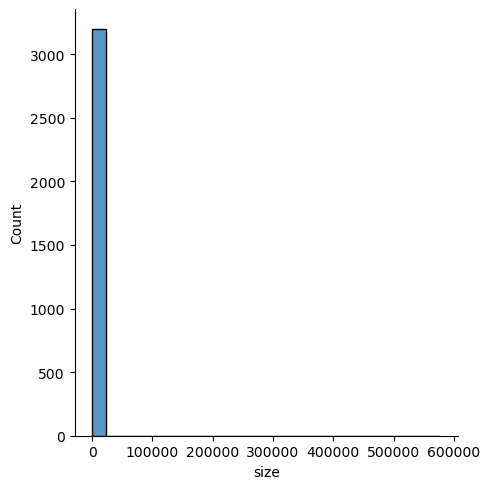

In [15]:
# Checking for Extreme values. It seems most of the fires are very small.
sns.displot(df_fires['size'], bins=25) # Shows extreme values


In [16]:
# Check the max

df_fires['size'].max()

577646.8

In [17]:
# Check the mean

df_fires['size'].mean()

266.68243826195857

In [18]:
# Check the median

df_fires['size'].median()

0.1

### 3. Data prep for regression analysis
** **

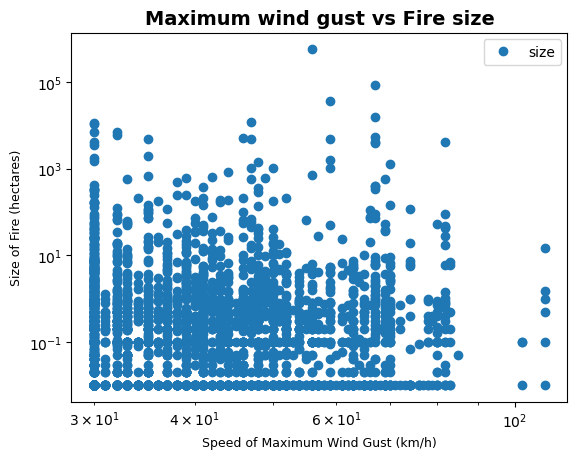

In [19]:
# Create a scatterplot using matplotlib for another look at how 'size' and 'maximum wind gust' variables plot against each other.

df_fires.plot(x = 'Speed of Maximum Wind Gust (km/h)', y='size',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Maximum wind gust vs Fire size', fontweight="bold" , fontsize = 14)  
plt.xlabel('Speed of Maximum Wind Gust (km/h)', fontsize = 9)  
plt.ylabel('Size of Fire (hectares)', fontsize = 9)  
plt.yscale('log')
plt.xscale('log')
plt.show()


### Hypothesis: The size of fire increases when the maximum wind gust goes up.

In [20]:
# Reshape the variables into NumPy arrays and put them into separate objects.

X = df_fires['Speed of Maximum Wind Gust (km/h)'].values.reshape(-1,1)
y = df_fires['size'].values.reshape(-1,1)

In [21]:
X

array([[39.],
       [39.],
       [39.],
       ...,
       [42.],
       [36.],
       [37.]])

In [22]:
y

array([[0.01],
       [0.01],
       [0.1 ],
       ...,
       [0.2 ],
       [0.1 ],
       [0.15]])

In [23]:
# Split data into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### 4. Regression analysis
** **

In [24]:
# Create a regression object. This is the regression object, which will be fit onto the training set.

regression = LinearRegression()  

In [25]:
# Fit the regression object onto the training set.

regression.fit(X_train, y_train)

LinearRegression()

In [26]:
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

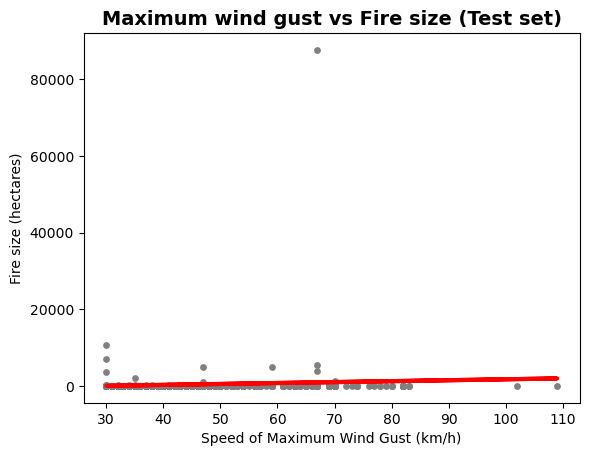

In [34]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Maximum wind gust vs Fire size (Test set)', fontsize = 14, fontweight = 'bold')
plot_test.xlabel('Speed of Maximum Wind Gust (km/h)')
plot_test.ylabel('Fire size (hectares)')
plot_test.show()

### Regression Line Interpretation:


The line doesn't fit very well to the data. This means that we don't seem to have a linear relationship between the maximum wind gust and size of fires. We will quantitatively examine this observation as well.

In [35]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [36]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[24.39411146]]
Mean squared error:  8279404.957118464
R2 score:  -2.429289668715029e-05


In [37]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,0.95,341.524379
1,0.01,1219.712391
2,0.80,292.736156
3,0.10,243.947933
4,0.30,24.400930
5,5.60,292.736156
6,7.75,24.400930
7,0.05,24.400930
8,0.01,24.400930
9,0.01,24.400930


##### Compare how the regression fits the training set

In [38]:
# Predict. This is predicting X_train!

y_predicted_train = regression.predict(X_train)

In [39]:
rmse = mean_squared_error(y_train, y_predicted_train)
r2 = r2_score(y_train, y_predicted_train)

In [40]:
print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[24.39411146]]
Mean squared error:  149757960.68274957
R2 score:  0.0006604244118865177


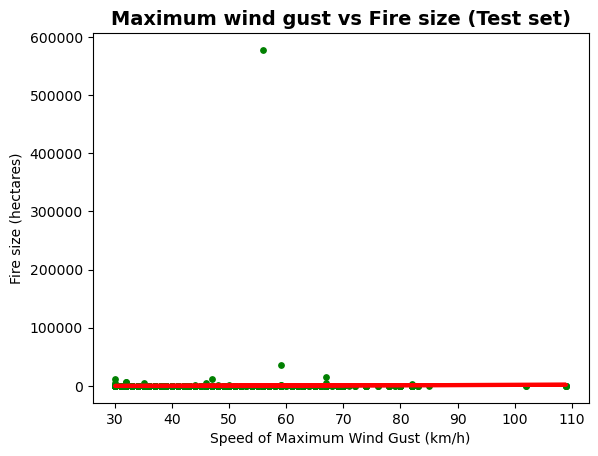

In [41]:
# Visualizing the training set results.

plot_test_tr = plt
plot_test_tr.scatter(X_train, y_train, color='green', s = 15)
plot_test_tr.plot(X_train, y_predicted_train, color='red', linewidth =3)
plot_test_tr.title('Maximum wind gust vs Fire size (Test set)', fontweight = 'bold', fontsize = 14)
plot_test_tr.xlabel('Speed of Maximum Wind Gust (km/h)')
plot_test_tr.ylabel('Fire size (hectares)')
plot_test_tr.show()

In [42]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [43]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[24.39411146]]
Mean squared error:  8279404.957118464
R2 score:  -2.429289668715029e-05


In [44]:
y_predicted

array([[ 341.52437866],
       [1219.7123913 ],
       [ 292.73615574],
       [ 243.94793282],
       [  24.40092966],
       [ 292.73615574],
       [  24.40092966],
       [  24.40092966],
       [  24.40092966],
       [  24.40092966],
       [  24.40092966],
       [ 341.52437866],
       [  24.40092966],
       [1000.16538814],
       [ 219.55382135],
       [ 683.04193913],
       [  73.18915258],
       [ 292.73615574],
       [  24.40092966],
       [ 512.2831589 ],
       [  24.40092966],
       [  24.40092966],
       [ 512.2831589 ],
       [  97.58326404],
       [  24.40092966],
       [ 195.15970989],
       [  24.40092966],
       [ 170.76559843],
       [ 463.49493597],
       [  97.58326404],
       [  24.40092966],
       [1146.53005691],
       [ 365.91849013],
       [  24.40092966],
       [ 146.37148697],
       [ 463.49493597],
       [ 487.88904744],
       [ 292.73615574],
       [ 561.07138182],
       [  24.40092966],
       [ 243.94793282],
       [  24.400

In [45]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,0.95,341.524379
1,0.01,1219.712391
2,0.80,292.736156
3,0.10,243.947933
4,0.30,24.400930
5,5.60,292.736156
6,7.75,24.400930
7,0.05,24.400930
8,0.01,24.400930
9,0.01,24.400930


### Results:
Applying the model on the test set plus the table of comparison between the actual and predicted values confirms that the data doesn't fit very well in a linear regression.

This might be due to the fact that weather station that we chose was not the best (the closest to the fire). In other word, the data might suffer from measurement bias.

In addition, the data has some visible outliers. As it is observed in the distribution plot, most of the data (size column) lies in the small values. In order to improve the model, we decided to use the 90 percentile of data to remove most of the outliers. Please follow the bonus task to see the details of this analysis.

### Bonus: performance improvement after removing outliers
** **


 We drow a new plot with 90% of data to remove most of the outliers.


In [46]:
# Finding the 90 percentile of data
np.percentile(df_fires['size'], 90)

5.0

In [47]:
sub = df_fires[df_fires['size'] < 2.09]

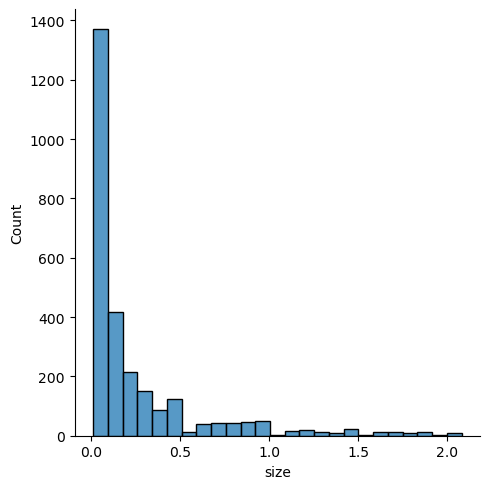

In [48]:
sns.displot(sub['size'], bins=25)


In [49]:
# Check the max

sub['size'].max()

2.08

In [50]:
# Check the median

sub['size'].median()

0.09

In [51]:
# Check the mean

sub['size'].mean()

0.23723054439166757

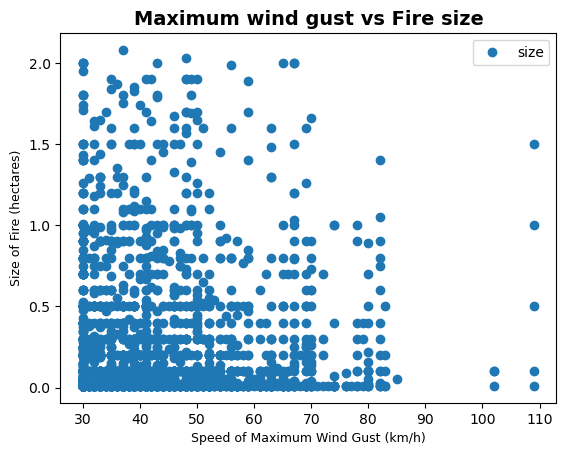

In [52]:
# Create a scatterplot using matplotlib for another look at how 'size' and 'maximum wind gust' variables plot against each other.

sub.plot(x = 'Speed of Maximum Wind Gust (km/h)', y='size',style='o') # The style option creates a scatterplot; without it, we only have lines.
plt.title('Maximum wind gust vs Fire size', fontweight="bold" , fontsize = 14)  
plt.xlabel('Speed of Maximum Wind Gust (km/h)', fontsize = 9)  
plt.ylabel('Size of Fire (hectares)', fontsize = 9)  
plt.show()

In [53]:
# Reshape the variables into NumPy arrays and put them into separate objects.

X = sub['Speed of Maximum Wind Gust (km/h)'].values.reshape(-1,1)
y = sub['size'].values.reshape(-1,1)

In [54]:
X

array([[39.],
       [39.],
       [39.],
       ...,
       [42.],
       [36.],
       [37.]])

In [55]:
y

array([[0.01],
       [0.01],
       [0.1 ],
       ...,
       [0.2 ],
       [0.1 ],
       [0.15]])

In [56]:
# Split data into a training set and a test set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [57]:
# Create a regression object. This is the regression object, which will be fit onto the training set.

regression = LinearRegression()  

In [58]:
# Fit the regression object onto the training set.

regression.fit(X_train, y_train)

LinearRegression()

In [59]:
# Predict the values of y using X.

y_predicted = regression.predict(X_test)

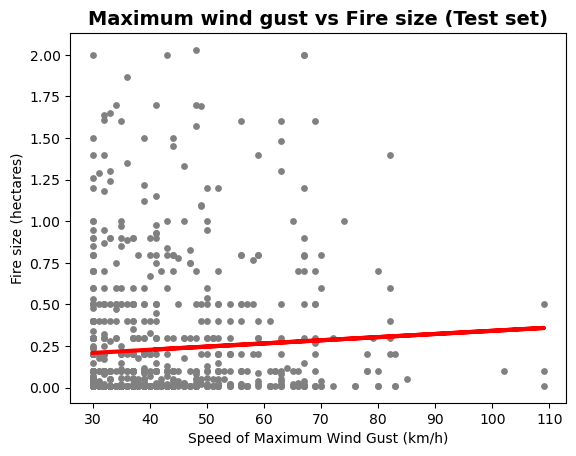

In [60]:
# Create a plot that shows the regression line from the model on the test set.

plot_test = plt
plot_test.scatter(X_test, y_test, color='gray', s = 15)
plot_test.plot(X_test, y_predicted, color='red', linewidth =3)
plot_test.title('Maximum wind gust vs Fire size (Test set)', fontsize = 14, fontweight = 'bold')
plot_test.xlabel('Speed of Maximum Wind Gust (km/h)')
plot_test.ylabel('Fire size (hectares)')
plot_test.show()

In [61]:
# Create objects that contain the model summary statistics.

rmse = mean_squared_error(y_test, y_predicted) # This is the mean squared error
r2 = r2_score(y_test, y_predicted) # This is the R2 score. 

In [62]:
# Print the model summary statistics. This is where you evaluate the performance of the model.

print('Slope:' ,regression.coef_)
print('Mean squared error: ', rmse)
print('R2 score: ', r2)

Slope: [[0.00189772]]
Mean squared error:  0.14883503949918184
R2 score:  0.0028100309536799317


In [63]:
# Create a dataframe comparing the actual and predicted values of y.

data = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predicted.flatten()})
data.head(30)

,Actual,Predicted
0,0.06,0.208522
1,0.30,0.282533
2,0.01,0.242681
3,0.05,0.208522
4,0.01,0.218011
5,0.01,0.210420
6,0.02,0.278737
7,0.50,0.208522
8,0.54,0.246476
9,0.10,0.208522


### Results:

Looking at the R Squared Scores of the two models, we observe that by removing outliers, the model slightly improves. However, we still do not see a strong relationship between the maximum wind gust (independent variable) and the fire size(dependent variable).